In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import pickle
from sklearn.feature_selection import f_classif, SelectKBest

## Predecir el coste del seguro médico de una persona



In [3]:
df = pd.read_csv('/workspaces/marcoakai_machine_learning/data/raw/medic.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


age. Edad del beneficiario principal (numérico)

sex. Género del beneficiario principal (categórico)

bmi. índice de masa corporal (numérico)

children. Número de niños/dependientes cubiertos por un seguro médico (numérico)

smoker. ¿Es fumador? (categórico)

region. Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)

charges. Prima del seguro médico (numérico)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.drop_duplicates()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [11]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [13]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

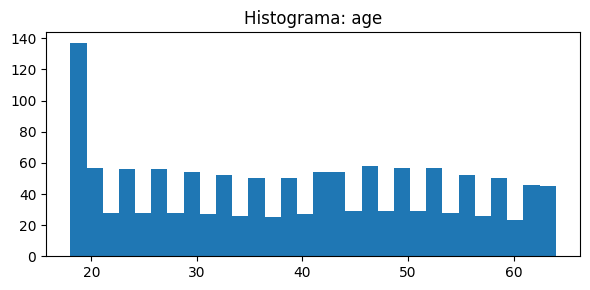

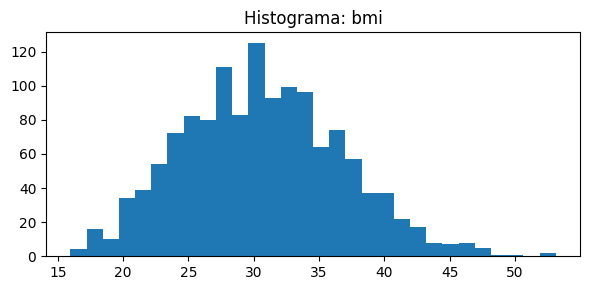

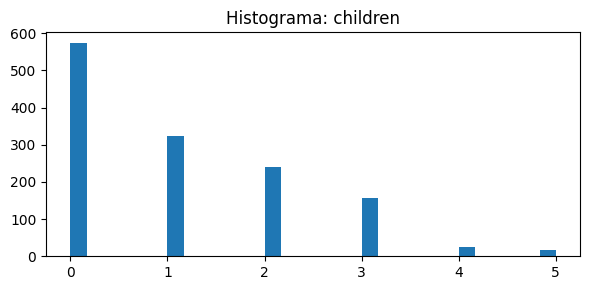

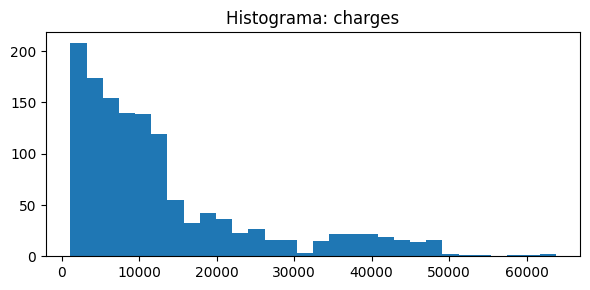

In [14]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histograma: {col}')
    plt.tight_layout()
    plt.show()

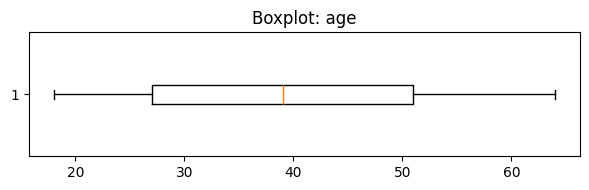

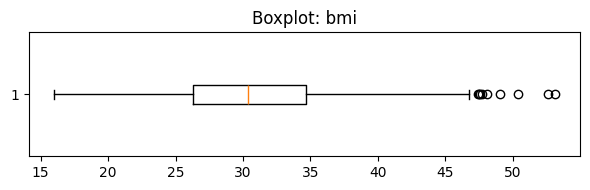

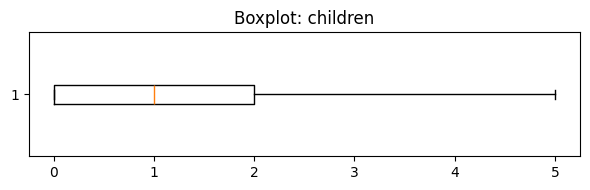

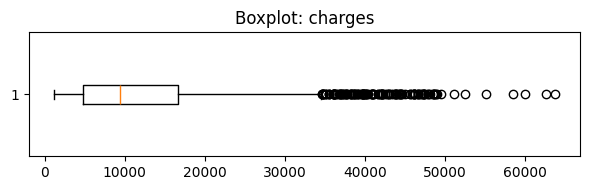

In [15]:
for col in numeric_cols:
    plt.figure(figsize=(6, 2))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

In [16]:
df[col].value_counts()

charges
1639.56310     2
2221.56445     1
19798.05455    1
13063.88300    1
13555.00490    1
              ..
1149.39590     1
37079.37200    1
4738.26820     1
2897.32350     1
4762.32900     1
Name: count, Length: 1337, dtype: int64

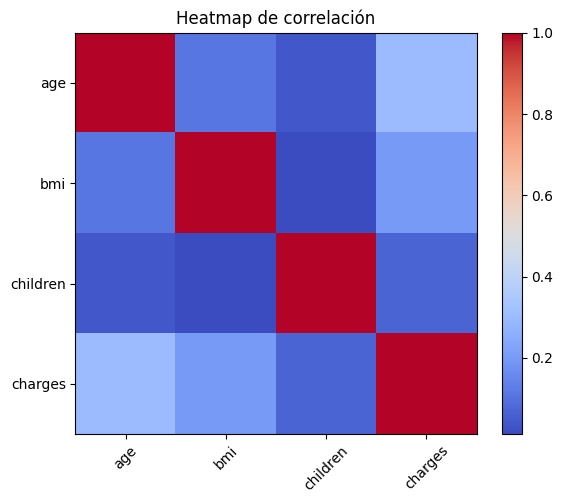

In [18]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Heatmap de correlación")
plt.tight_layout()
plt.show()